# **Time Series Forecasting for Cryptocurrency Price Direction**

In [ ]:
# Import all packages here
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, ParameterGrid
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

### **Step 1: Data Preprocessing and Exploration**
Load the train.csv and test.csv files, handle missing values and potential outliers. Explore the datasets with summary statistics and visualize key features and target variables. Consider the time series nature of the data when analyzing patterns like trends and seasonality.

In [ ]:
# Load the data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [ ]:
print(train_df.shape)
print(test_df.shape)

(2122438, 11)
(909617, 11)


In [ ]:
train_df.head()

,timestamp,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_volume,taker_buy_quote_volume,target
0,1525471260,0.90120,0.90130,0.90120,0.90130,134.98,121.646459,4.0,125.08,112.723589,1.0
1,1525471320,0.90185,0.90195,0.90185,0.90195,1070.54,965.505313,12.0,879.94,793.612703,0.0
2,1525471380,0.90140,0.90140,0.90139,0.90139,2293.06,2066.963991,5.0,0.00,0.000000,0.0
3,1525471440,0.90139,0.90140,0.90138,0.90139,6850.59,6175.000909,19.0,1786.30,1610.149485,0.0
4,1525471500,0.90139,0.90139,0.90130,0.90130,832.30,750.222624,3.0,784.82,707.428900,0.0


In [ ]:
test_df.head()

,row_id,timestamp,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_volume,taker_buy_quote_volume
0,0,1652817480,0.4306,0.4308,0.4301,0.4301,101150.0,43542.2629,105.0,46109.0,19851.7237
1,1,1652817540,0.4301,0.4303,0.4293,0.4302,275647.0,118478.9689,228.0,91260.0,39217.6312
2,2,1652817600,0.4302,0.4302,0.4292,0.4299,134959.0,57979.2418,156.0,56685.0,24357.5448
3,3,1652817660,0.4299,0.4303,0.4299,0.4301,316209.0,135979.4040,121.0,161740.0,69552.2691
4,4,1652817720,0.4302,0.4307,0.4302,0.4303,107440.0,46243.7993,113.0,31096.0,13384.3384


In [ ]:
# Check for missing values
print(train_df.isnull().sum())
print(test_df.isnull().sum())

# train_df = train_df.dropna()
# test_df = test_df.dropna()

timestamp                 0
open                      0
high                      0
low                       0
close                     0
volume                    0
quote_asset_volume        0
number_of_trades          0
taker_buy_base_volume     0
taker_buy_quote_volume    0
target                    0
dtype: int64
row_id                    0
timestamp                 0
open                      0
high                      0
low                       0
close                     0
volume                    0
quote_asset_volume        0
number_of_trades          0
taker_buy_base_volume     0
taker_buy_quote_volume    0
dtype: int64


In [ ]:
# Basic statistics and info
print(train_df.describe())

          timestamp          open          high           low         close  \
count  2.122438e+06  2.122438e+06  2.122438e+06  2.122438e+06  2.122438e+06   
mean   1.589144e+09  4.971020e-01  4.976028e-01  4.965936e-01  4.971011e-01   
std    3.676171e+07  3.147919e-01  3.152553e-01  3.143317e-01  3.147945e-01   
min    1.525471e+09  1.057300e-01  1.068400e-01  1.012900e-01  1.058900e-01   
25%    1.557308e+09  2.676100e-01  2.678200e-01  2.673900e-01  2.676000e-01   
50%    1.589144e+09  3.629800e-01  3.633400e-01  3.626000e-01  3.629700e-01   
75%    1.620981e+09  6.572000e-01  6.579550e-01  6.563000e-01  6.572000e-01   
max    1.652817e+09  1.964710e+00  1.966890e+00  1.958350e+00  1.964710e+00   

             volume  quote_asset_volume  number_of_trades  \
count  2.122438e+06        2.122438e+06      2.122438e+06   
mean   2.484890e+05        1.650106e+05      2.121758e+02   
std    6.416383e+05        4.887013e+05      5.372650e+02   
min    0.000000e+00        0.000000e+00     

In [ ]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2122438 entries, 0 to 2122437
Data columns (total 11 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   timestamp               int64  
 1   open                    float64
 2   high                    float64
 3   low                     float64
 4   close                   float64
 5   volume                  float64
 6   quote_asset_volume      float64
 7   number_of_trades        float64
 8   taker_buy_base_volume   float64
 9   taker_buy_quote_volume  float64
 10  target                  float64
dtypes: float64(10), int64(1)
memory usage: 178.1 MB
None


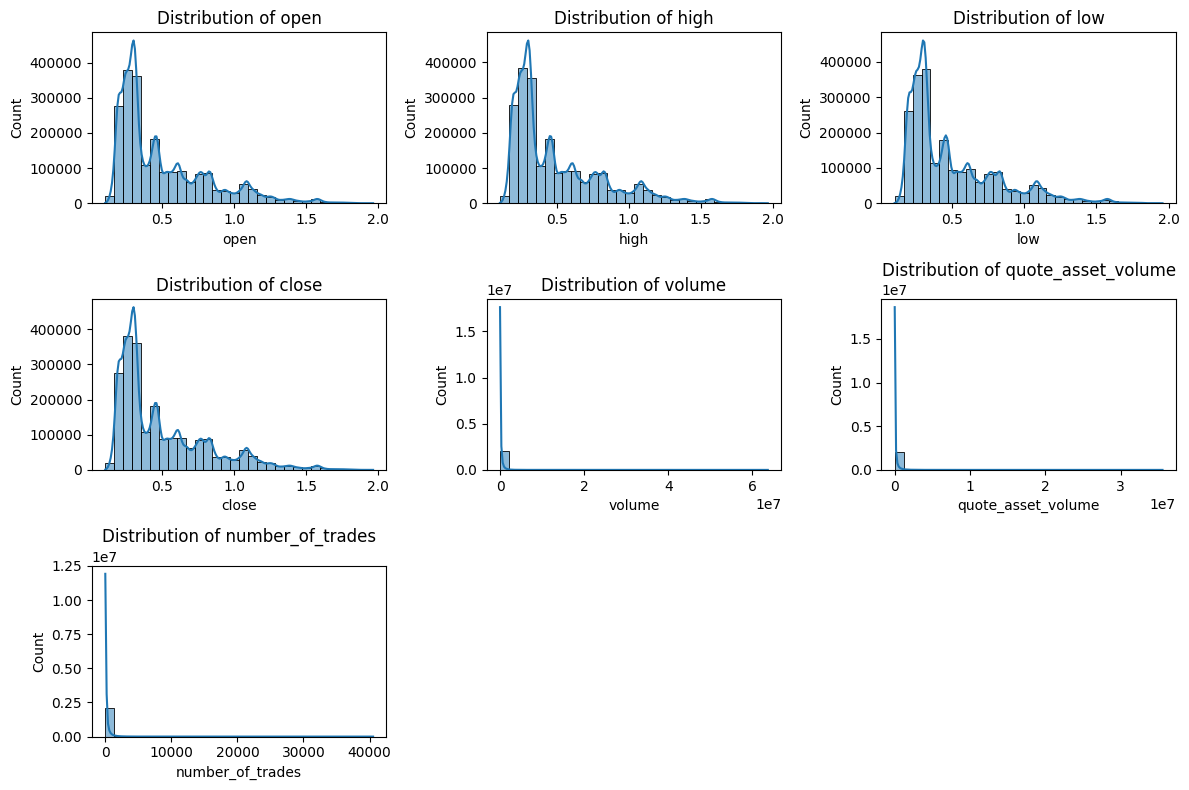

In [ ]:
# Visualizing feature distributions
features = ['open', 'high', 'low', 'close', 'volume', 'quote_asset_volume', 'number_of_trades']

plt.figure(figsize=(12, 8))
for i, feature in enumerate(features):
    plt.subplot(3, 3, i + 1)
    sns.histplot(train_df[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

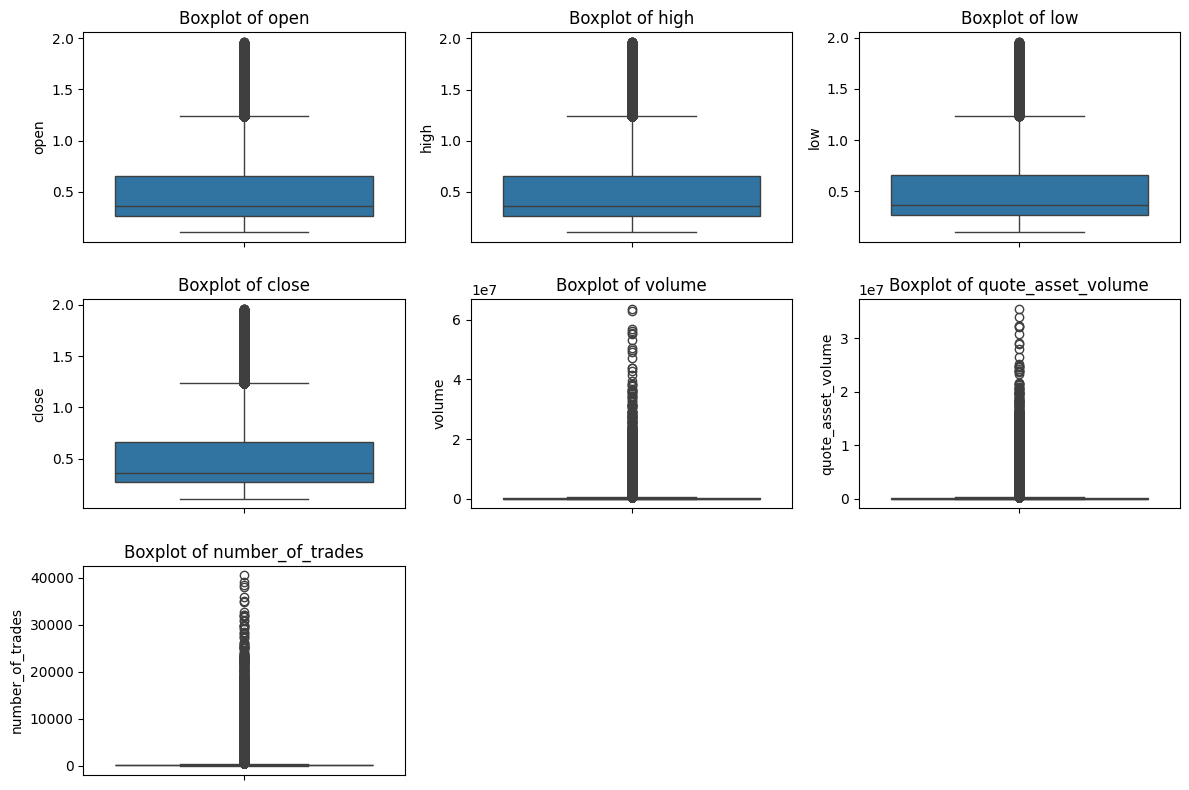

In [ ]:
# Detecting outliers with boxplots
plt.figure(figsize=(12, 8))
for i, feature in enumerate(features):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=train_df[feature])
    plt.title(f'Boxplot of {feature}')
plt.tight_layout()
plt.show()

In [ ]:
# Romoving outliers using IQR (Interquartile Range)
def remove_outliers(df, features):
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
    return df

# Remove outliers from the train data
train_df_cleaned = remove_outliers(train_df, features)

In [ ]:
# print(train_df_cleaned.describe())

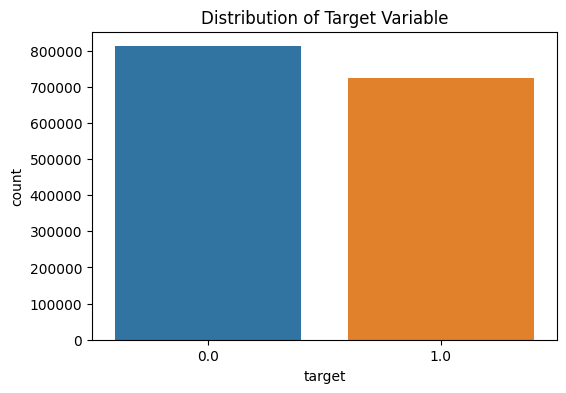

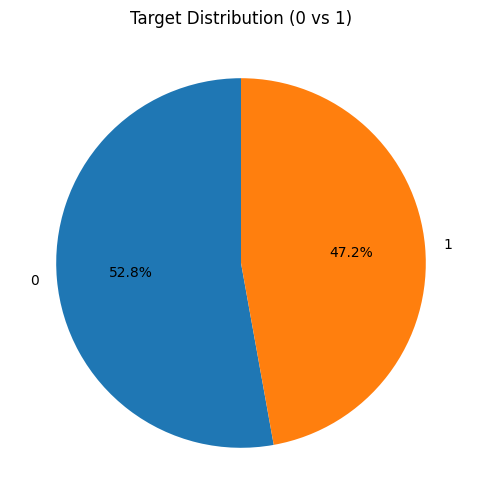

In [ ]:
# Visualizing the target variable
plt.figure(figsize=(6, 4))
sns.countplot(x=train_df_cleaned['target'], hue=train_df_cleaned['target'], palette=["#1f77b4", "#ff7f0e"], legend=False)
plt.title('Distribution of Target Variable')
plt.show()

plt.figure(figsize=(6, 6))
plt.pie(
    train_df_cleaned['target'].value_counts().values,
    labels=[0, 1],
    autopct='%1.1f%%',
    colors=["#1f77b4", "#ff7f0e"],
    startangle=90
)
plt.title('Target Distribution (0 vs 1)')
plt.show()

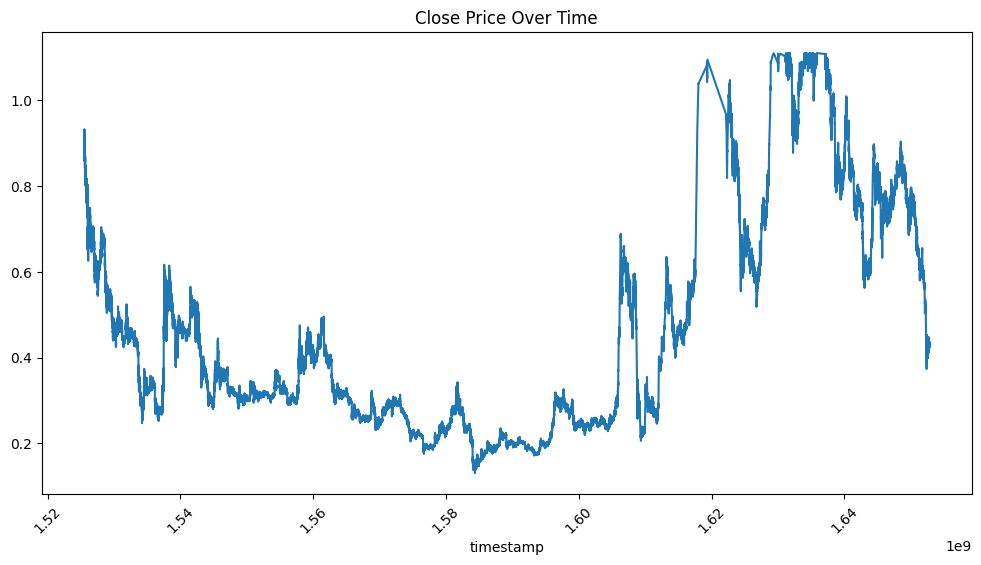

In [ ]:
# Time-series exploration of "close" price
plt.figure(figsize=(12, 6))
train_df_cleaned.set_index('timestamp')['close'].plot()
plt.title('Close Price Over Time')
plt.xticks(rotation=45)
plt.show()

### **Step 2: Feature Engineering**
Create new features like price change, log return, volatility, and so on. Use a correlation matrix to drop irrelevant features and retain only those that are highly correlated with the target.

In [ ]:
# Creating new features in train_df_cleaned
train_df_cleaned['price_change'] = train_df_cleaned['close'] - train_df_cleaned['open']
train_df_cleaned['price_change_pct'] = ((train_df_cleaned['close'] - train_df_cleaned['open']) / train_df_cleaned['open']) * 100
train_df_cleaned['log_return'] = np.log(train_df_cleaned['close'] / train_df_cleaned['open'])
train_df_cleaned['high_to_open'] = train_df_cleaned['high'] / train_df_cleaned['open']
train_df_cleaned['price_up'] = (train_df_cleaned['close'] > train_df_cleaned['open']).astype(int)
train_df_cleaned['cumulative_avg_price'] = train_df_cleaned['close'].expanding().mean()

for period in [5, 10, 20, 50, 100]:
    train_df_cleaned[f'EMA_{period}'] = train_df_cleaned['close'].ewm(span=period, adjust=False).mean()

train_df_cleaned['close_to_high'] = train_df_cleaned['close'] / train_df_cleaned['high']
train_df_cleaned['close_to_low'] = train_df_cleaned['close'] / train_df_cleaned['low']
train_df_cleaned['high_low_ratio'] = train_df_cleaned['high'] / train_df_cleaned['low']
train_df_cleaned['close_open_ratio'] = train_df_cleaned['close'] / train_df_cleaned['open']
train_df_cleaned['volume_to_high'] = train_df_cleaned['volume'] / train_df_cleaned['high']
train_df_cleaned['volume_to_low'] = train_df_cleaned['volume'] / train_df_cleaned['low']
train_df_cleaned['absolute_volatility'] = train_df_cleaned['high'] - train_df_cleaned['low']
train_df_cleaned['relative_volatility'] = (train_df_cleaned['high'] - train_df_cleaned['low']) / train_df_cleaned['low']
train_df_cleaned['cumulative_avg_close'] = train_df_cleaned['close'].expanding().mean()
train_df_cleaned['cumulative_avg_open'] = train_df_cleaned['open'].expanding().mean()
train_df_cleaned['cumulative_price_change'] = (train_df_cleaned['close'] - train_df_cleaned['open']).cumsum()
train_df_cleaned['is_uptrend'] = (train_df_cleaned['close'] > train_df_cleaned['open']).astype(int)
train_df_cleaned['mid_price'] = (train_df_cleaned['high'] + train_df_cleaned['low']) / 2

In [ ]:
# Checking missing values after adding features
print(train_df_cleaned.isnull().sum())

open                       0
high                       0
low                        0
close                      0
volume                     0
number_of_trades           0
taker_buy_base_volume      0
target                     0
price_change               0
price_change_pct           0
log_return                 0
price_up                   0
cumulative_avg_price       0
EMA_5                      0
EMA_10                     0
EMA_20                     0
EMA_50                     0
EMA_100                    0
high_to_open               0
close_to_high              0
close_to_low               0
high_low_ratio             0
close_open_ratio           0
volume_to_high             0
volume_to_low              0
absolute_volatility        0
relative_volatility        0
cumulative_avg_close       0
cumulative_avg_open        0
cumulative_price_change    0
is_uptrend                 0
mid_price                  0
dtype: int64


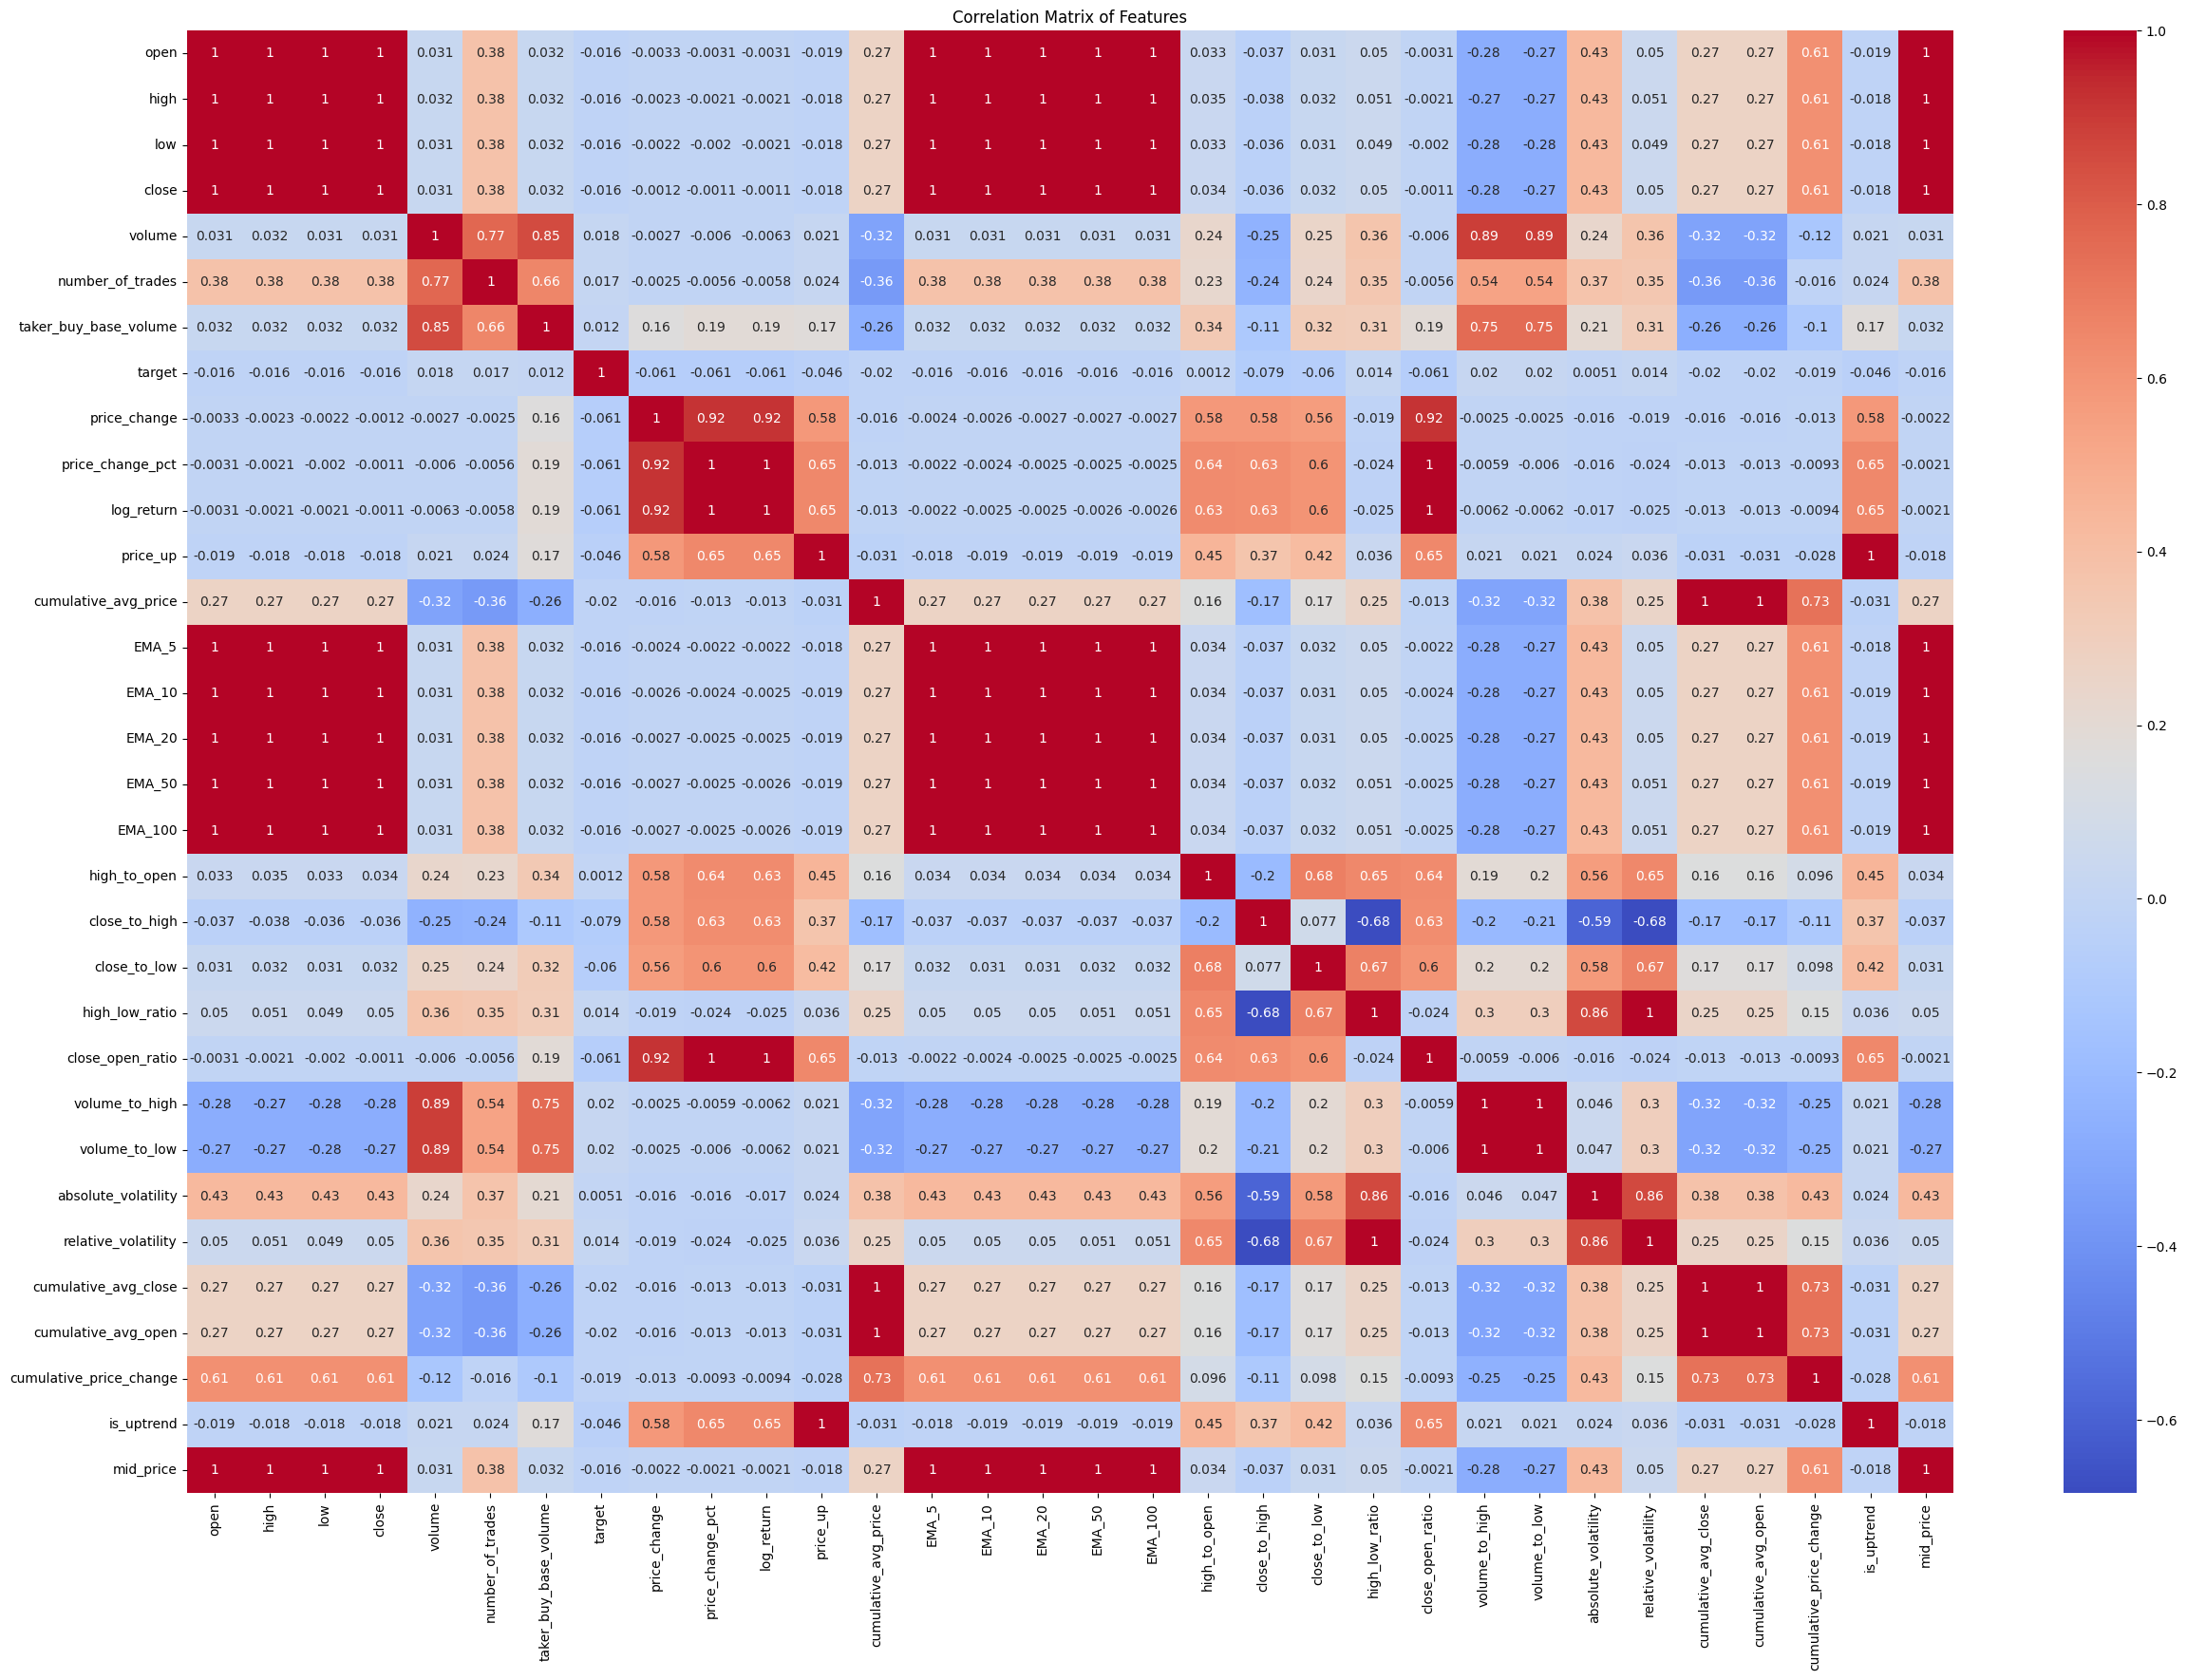

In [ ]:
# Plotting correlation matrix to inspect feature relevance to the target
plt.figure(figsize=(30, 20))
corr_matrix = train_df_cleaned.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()

In [ ]:
# Dropping irrelevant features with correlation less than 0.1 to the target
low_correlation_features = corr_matrix['target'][corr_matrix['target'].abs() < 0.01].index
train_df_cleaned = train_df_cleaned.drop(columns=low_correlation_features)

print(train_df_cleaned.columns) # Remaining Features

Index(['open', 'high', 'low', 'close', 'volume', 'number_of_trades',
       'taker_buy_base_volume', 'target', 'price_change', 'price_change_pct',
       'log_return', 'price_up', 'cumulative_avg_price', 'EMA_5', 'EMA_10',
       'EMA_20', 'EMA_50', 'EMA_100', 'close_to_high', 'close_to_low',
       'high_low_ratio', 'close_open_ratio', 'volume_to_high', 'volume_to_low',
       'relative_volatility', 'cumulative_avg_close', 'cumulative_avg_open',
       'cumulative_price_change', 'is_uptrend', 'mid_price'],
      dtype='object')


In [ ]:
train_df_cleaned # This is our final training data

,open,high,low,close,volume,number_of_trades,taker_buy_base_volume,target,price_change,price_change_pct,...,high_low_ratio,close_open_ratio,volume_to_high,volume_to_low,relative_volatility,cumulative_avg_close,cumulative_avg_open,cumulative_price_change,is_uptrend,mid_price
0,0.90120,0.90130,0.90120,0.90130,134.98,4.0,125.08,1.0,0.00010,0.011096,...,1.000111,1.000111,149.761456,149.778074,0.000111,0.901300,0.901200,0.00010,1,0.901250
1,0.90185,0.90195,0.90185,0.90195,1070.54,12.0,879.94,0.0,0.00010,0.011088,...,1.000111,1.000111,1186.917235,1187.048844,0.000111,0.901625,0.901525,0.00020,1,0.901900
2,0.90140,0.90140,0.90139,0.90139,2293.06,5.0,0.00,0.0,-0.00001,-0.001109,...,1.000011,0.999989,2543.887286,2543.915508,0.000011,0.901547,0.901483,0.00019,0,0.901395
3,0.90139,0.90140,0.90138,0.90139,6850.59,19.0,1786.30,0.0,0.00000,0.000000,...,1.000022,1.000000,7599.944531,7600.113160,0.000022,0.901508,0.901460,0.00019,0,0.901390
4,0.90139,0.90139,0.90130,0.90130,832.30,3.0,784.82,0.0,-0.00009,-0.009985,...,1.000100,0.999900,923.351712,923.443914,0.000100,0.901466,0.901446,0.00010,0,0.901345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2122433,0.43060,0.43060,0.42990,0.43040,136274.00,144.0,54216.00,1.0,-0.00020,-0.046447,...,1.001628,0.999536,316474.686484,316989.997674,0.001628,0.384476,0.384478,-2.74360,0,0.430250
2122434,0.43030,0.43070,0.43030,0.43050,104478.00,99.0,52232.00,1.0,0.00020,0.046479,...,1.000930,1.000465,242577.199907,242802.695794,0.000930,0.384476,0.384478,-2.74340,1,0.430500
2122435,0.43050,0.43120,0.43050,0.43090,212396.00,177.0,108324.00,0.0,0.00040,0.092915,...,1.001626,1.000929,492569.573284,493370.499419,0.001626,0.384476,0.384478,-2.74300,1,0.430850
2122436,0.43110,0.43110,0.43040,0.43060,131047.00,107.0,32713.00,0.0,-0.00050,-0.115982,...,1.001626,0.998840,303982.834609,304477.230483,0.001626,0.384476,0.384478,-2.74350,0,0.430750


### **Step 3: Train-Test Split**
Split the training data into 80% for training and 20% for validation, ensuring the split respects the time-series order to avoid data leakage. Also do Normalization (scaling data between 0 and 1) to scale to a smaller range of data that helping stabilize gradients during training and can lead to better convergence.

In [ ]:
# Separating features (X) and target (y)
X = train_df_cleaned.drop(columns=['target'])
y = train_df_cleaned['target']

In [ ]:
train_size = int(0.8 * len(X)) # Define the split index based on an 80-20 split

# Perform an 80%-20% split for training and validation
train_size = int(len(X) * 0.8)
X_train, X_val = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_val = y.iloc[:train_size], y.iloc[train_size:]

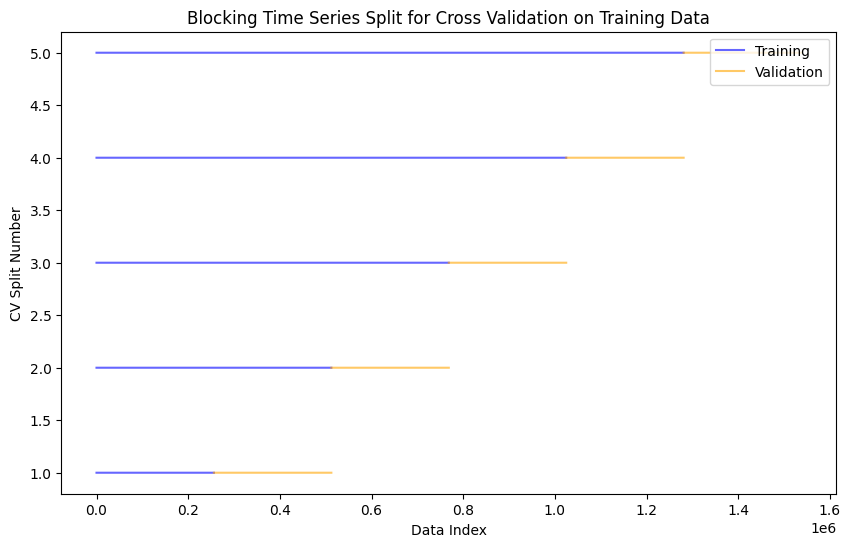

X_train Shape: (1229586, 29)
X_val Shape: (307397, 29)
y_train Shape: (1229586,)
y_val Shape: (307397,)


In [ ]:
# Set up Blocking Time Series Split for Cross Validation
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

X_train_splits = []
X_val_splits = []
y_train_splits = []
y_val_splits = []

plt.figure(figsize=(10, 6))
for i, (train_index, val_index) in enumerate(tscv.split(X)):
  # Split data for this cross-validation fold
  X_train_cv, X_val_cv = X.iloc[train_index], X.iloc[val_index]
  y_train_cv, y_val_cv = y.iloc[train_index], y.iloc[val_index]

  X_train_splits.append(X_train_cv)
  X_val_splits.append(X_val_cv)
  y_train_splits.append(y_train_cv)
  y_val_splits.append(y_val_cv)

  # Plot the indices for each fold
  plt.plot(train_index, [i + 1] * len(train_index), color="blue", label="Training" if i == 0 else "", alpha=0.6)
  plt.plot(val_index, [i + 1] * len(val_index), color="orange", label="Validation" if i == 0 else "", alpha=0.6)

plt.xlabel("Data Index")
plt.ylabel("CV Split Number")
plt.title("Blocking Time Series Split for Cross Validation on Training Data")
plt.legend(loc="upper right")
plt.show()

print("X_train Shape:", X_train.shape)
print("X_val Shape:", X_val.shape)
print("y_train Shape:", y_train.shape)
print("y_val Shape:", y_val.shape)

In [ ]:
# Normalization
scaler_normal = MinMaxScaler()

X_train_normalized = scaler_normal.fit_transform(X_train)
X_val_normalized = scaler_normal.transform(X_val)

### **Step 4: Baseline Model (Logistic Regression)**
Build a simple logistic regression model as a baseline. Evaluate its performance using accuracy, precision, recall, and the F1 score to set a benchmark for comparison with more advanced models.

In [ ]:
# Training a baseline model - Logistic Regression
baseline_model = LogisticRegression(max_iter=1000, random_state=42)
baseline_model.fit(X_train_normalized, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
# Evaluate the baseline model
y_pred_baseline = baseline_model.predict(X_val_normalized)

accuracy = accuracy_score(y_val, y_pred_baseline)
precision = precision_score(y_val, y_pred_baseline)
recall = recall_score(y_val, y_pred_baseline)
f1 = f1_score(y_val, y_pred_baseline)

print(f'Baseline Model Performance:')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Baseline Model Performance:
Accuracy: 0.5045
Precision: 0.4758
Recall: 0.5955
F1 Score: 0.5290


> Logistic Regression is our baseline model.  The low F1 score indicates that the model is struggling to capture the target variable correctly. But since it is a very simple model and may not perform well on complex datasets like this one, especially in a highly volatile market like cryptocurrency. Therefore, let's move on to the next step to train more advanced and complex models and try to beat it.

### **Step 5: Advanced Models**
Train more complex models such as Random Forest (RF), Gradient Boosting (GB), Long Short-Term Memory (LSTM), and Gated Recurrent Unit (GRU). These models are well-suited for time-series data and have shown good performance in predicting cryptocurrency prices in my research.

In [ ]:
# Random Forest (RF)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_normalized, y_train)

# Evaluate the model
y_pred_rf = rf_model.predict(X_val_normalized)

accuracy_rf = accuracy_score(y_val, y_pred_rf)
precision_rf = precision_score(y_val, y_pred_rf)
recall_rf = recall_score(y_val, y_pred_rf)
f1_rf = f1_score(y_val, y_pred_rf)

print(f'Random Forest Performance:')
print(f'Accuracy: {accuracy_rf:.4f}')
print(f'Precision: {precision_rf:.4f}')
print(f'Recall: {recall_rf:.4f}')
print(f'F1 Score: {f1_rf:.4f}')

Random Forest Performance:
Accuracy: 0.5154
Precision: 0.4684
Recall: 0.2773
F1 Score: 0.3484


In [ ]:
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
feature_importances = feature_importances.sort_values(ascending=False)

print(rf_model)
print(rf_model.get_params())
print("Feature Importances:")
print(feature_importances)

RandomForestClassifier(random_state=42)
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Feature Importances:
taker_buy_base_volume      0.053596
close_to_high              0.048519
close_to_low               0.046565
cumulative_price_change    0.045542
volume                     0.045450
high_low_ratio             0.044326
volume_to_high             0.044268
volume_to_low              0.044209
relative_volatility        0.044196
number_of_trades           0.042620
cumulative_avg_close       0.039795
cumulative_avg_open        0.039730
cumulative_avg_price       0.039714
close_open_ratio           0.038561
log_return           

In [ ]:
# Gradient Boosting (GB) using XGBoost
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train_normalized, y_train)

# Evaluate the model
y_pred_xgb = xgb_model.predict(X_val_normalized)

accuracy_xgb = accuracy_score(y_val, y_pred_xgb)
precision_xgb = precision_score(y_val, y_pred_xgb)
recall_xgb = recall_score(y_val, y_pred_xgb)
f1_xgb = f1_score(y_val, y_pred_xgb)

print(f'XGBoost Performance:')
print(f'Accuracy: {accuracy_xgb:.4f}')
print(f'Precision: {precision_xgb:.4f}')
print(f'Recall: {recall_xgb:.4f}')
print(f'F1 Score: {f1_xgb:.4f}')

XGBoost Performance:
Accuracy: 0.5278
Precision: 0.4837
Recall: 0.1582
F1 Score: 0.2384


In [ ]:
feature_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
feature_importances = feature_importances.sort_values(ascending=False)

print(xgb_model)
print(xgb_model.get_params())
print("Feature Importances:")
print(feature_importances)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)
{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval

In [ ]:
# Long Short-Term Memory (LSTM)
# Reshaping the input data for LSTM
X_train_lstm = np.reshape(X_train_normalized, (X_train_normalized.shape[0], 1, X_train_normalized.shape[1]))
X_val_lstm = np.reshape(X_val_normalized, (X_val_normalized.shape[0], 1, X_val_normalized.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(units=50, input_shape=(1, X_train_normalized.shape[1])))
lstm_model.add(Dense(1, activation='sigmoid'))  # Binary classification

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=64, validation_data=(X_val_lstm, y_val))

# Evaluate the model
y_pred_lstm = (lstm_model.predict(X_val_lstm) > 0.5).astype("int32")

accuracy_lstm = accuracy_score(y_val, y_pred_lstm)
precision_lstm = precision_score(y_val, y_pred_lstm)
recall_lstm = recall_score(y_val, y_pred_lstm)
f1_lstm = f1_score(y_val, y_pred_lstm)

print(f'LSTM Performance:')
print(f'Accuracy: {accuracy_lstm:.4f}')
print(f'Precision: {precision_lstm:.4f}')
print(f'Recall: {recall_lstm:.4f}')
print(f'F1 Score: {f1_lstm:.4f}')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 67s 3ms/step - accuracy: 0.5400 - loss: 0.6869 - val_accuracy: 0.5223 - val_loss: 0.6920
Epoch 2/10
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 67s 3ms/step - accuracy: 0.5560 - loss: 0.6821 - val_accuracy: 0.4947 - val_loss: 0.6978
Epoch 3/10
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step - accuracy: 0.5585 - loss: 0.6811 - val_accuracy: 0.4815 - val_loss: 0.7035
Epoch 4/10
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 67s 3ms/step - accuracy: 0.5596 - loss: 0.6806 - val_accuracy: 0.4931 - val_loss: 0.7003
Epoch 5/10
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step - accuracy: 0.5609 - loss: 0.6800 - val_accuracy: 0.4898 - val_loss: 0.6999
Epoch 6/10
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 68s 4ms/step - accuracy: 0.5596 - loss: 0.6802 - val_accuracy: 0.5020 - val_loss: 0.6967
Epoch 7/10
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step - accuracy: 0.5607 - loss: 0.6801 - val_accuracy: 0.4932 - val_loss: 0.7017
Epoch 8/10
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step - accuracy: 

In [ ]:
lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 50)                  │          16,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,155 (188.11 KB)

 Trainable params: 16,051 (62.70 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 32,104 (125.41 KB)

In [ ]:
# Gated Recurrent Unit (GRU)
# Reshaping the input data for GRU
X_train_gru = np.reshape(X_train_normalized, (X_train_normalized.shape[0], 1, X_train_normalized.shape[1]))
X_val_gru = np.reshape(X_val_normalized, (X_val_normalized.shape[0], 1, X_val_normalized.shape[1]))

gru_model = Sequential()
gru_model.add(GRU(units=50, input_shape=(1, X_train_normalized.shape[1])))
gru_model.add(Dense(1, activation='sigmoid'))  # Binary classification

gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
gru_model.fit(X_train_gru, y_train, epochs=10, batch_size=64, validation_data=(X_val_gru, y_val))

# Evaluate the model
y_pred_gru = (gru_model.predict(X_val_gru) > 0.5).astype("int32")

accuracy_gru = accuracy_score(y_val, y_pred_gru)
precision_gru = precision_score(y_val, y_pred_gru)
recall_gru = recall_score(y_val, y_pred_gru)
f1_gru = f1_score(y_val, y_pred_gru)

print(f'GRU Performance:')
print(f'Accuracy: {accuracy_gru:.4f}')
print(f'Precision: {precision_gru:.4f}')
print(f'Recall: {recall_gru:.4f}')
print(f'F1 Score: {f1_gru:.4f}')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step - accuracy: 0.5400 - loss: 0.6871 - val_accuracy: 0.5061 - val_loss: 0.6939
Epoch 2/10
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 65s 3ms/step - accuracy: 0.5540 - loss: 0.6825 - val_accuracy: 0.5130 - val_loss: 0.6935
Epoch 3/10
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step - accuracy: 0.5578 - loss: 0.6814 - val_accuracy: 0.4965 - val_loss: 0.6995
Epoch 4/10
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 65s 3ms/step - accuracy: 0.5590 - loss: 0.6809 - val_accuracy: 0.5194 - val_loss: 0.6927
Epoch 5/10
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 65s 3ms/step - accuracy: 0.5603 - loss: 0.6805 - val_accuracy: 0.4979 - val_loss: 0.6998
Epoch 6/10
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 65s 3ms/step - accuracy: 0.5602 - loss: 0.6804 - val_accuracy: 0.4779 - val_loss: 0.7141
Epoch 7/10
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 64s 3ms/step - accuracy: 0.5602 - loss: 0.6802 - val_accuracy: 0.4758 - val_loss: 0.7151
Epoch 8/10
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 65s 3ms/step - accuracy: 

In [ ]:
gru_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 50)                  │          12,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,605 (142.99 KB)

 Trainable params: 12,201 (47.66 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 24,404 (95.33 KB)

### **Step 6: Model Selection**
Compare all models based on accuracy, precision, recall, and F1 score. Focus on selecting the model with the highest F1 score, as it is the competition’s evaluation metric.

In [ ]:
# Comparing the performances for all models
baseline_metrics = {
    'Model': 'Baseline (Logistic Regression)',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
}

rf_metrics = {
    'Model': 'Random Forest',
    'Accuracy': accuracy_rf,
    'Precision': precision_rf,
    'Recall': recall_rf,
    'F1 Score': f1_rf
}

xgb_metrics = {
    'Model': 'XGBoost',
    'Accuracy': accuracy_xgb,
    'Precision': precision_xgb,
    'Recall': recall_xgb,
    'F1 Score': f1_xgb
}

lstm_metrics = {
    'Model': 'LSTM',
    'Accuracy': accuracy_lstm,
    'Precision': precision_lstm,
    'Recall': recall_lstm,
    'F1 Score': f1_lstm
}

gru_metrics = {
    'Model': 'GRU',
    'Accuracy': accuracy_gru,
    'Precision': precision_gru,
    'Recall': recall_gru,
    'F1 Score': f1_gru
}

In [ ]:
# Sort the models by F1 Score
model_comparisons = [baseline_metrics, rf_metrics, xgb_metrics, lstm_metrics, gru_metrics]
df_comparison_sorted = pd.DataFrame(model_comparisons).set_index('Model').sort_values(by='F1 Score', ascending=False)

print("\nModel Ranking Based on F1 Score:\n")
df_comparison_sorted


Model Ranking Based on F1 Score:



,Accuracy,Precision,Recall,F1 Score
Model,,,,
GRU,0.495223,0.472323,0.686416,0.559591
Baseline (Logistic Regression),0.504507,0.475800,0.595471,0.528952
LSTM,0.496456,0.469220,0.593055,0.523920
Random Forest,0.515353,0.468444,0.277278,0.348358
XGBoost,0.527835,0.483732,0.158188,0.238412


> The above table is ordered by the F1 Socre. Overall, the F1 Scores of GRU, Logistic Regression, and LSTM are above 50%, and the GRU model achieves the hignest one with a 56% F1 Score. Generally, a 56% F1 score in cryptocurrency prediction reflects a moderate level of effectiveness, better than random guessing, but still not sufficient for practical use. However, since we have not yet done any fine-tuning for our models, a 56% F1 score is an acceptable starting point.

👉🏻 Let's pick up GRU as our best-performance model and find ways to improve its prediction accuracy and F1 score!

### **Step 7: Hyperparameter Tuning**
Fine-tune to optimize the hyperparameters of the best-performing model, aiming to maximize the F1 score on the validation set.

In [ ]:
# Define a function to create and compile a GRU model
def create_gru_model(units=50, dropout_rate=0.3, learning_rate=0.001):
    model = Sequential()
    model.add(GRU(units=units, input_shape=(1, X_train_normalized.shape[1])))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define the parameter grid for fine-tuning
param_grid = {
    'units': [32, 50, 64],
    'dropout_rate': [0.2, 0.3, 0.5],
    'learning_rate': [0.001, 0.0001],
    'batch_size': [32, 64],
    'epochs': [50]
}

best_f1 = 0
best_params = None
best_model = None
grid = list(ParameterGrid(param_grid))
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

for params in grid:
    print(f"\nTesting parameters: {params}")

    model = create_gru_model(units=params['units'],
                             dropout_rate=params['dropout_rate'],
                             learning_rate=params['learning_rate'])

    history = model.fit(X_train_gru, y_train,
                        validation_data=(X_val_gru, y_val),
                        epochs=params['epochs'],
                        batch_size=params['batch_size'],
                        callbacks=[early_stopping],
                        verbose=1)

    y_val_pred_proba = model.predict(X_val_gru)
    y_val_pred = (y_val_pred_proba > 0.5).astype(int)

    f1 = f1_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred)

    print(f"F1 Score: {f1}, Precision: {precision}, Recall: {recall} for parameters: {params}")

    if f1 > best_f1:
        best_f1 = f1
        best_params = params
        best_model = model
        print("New best model found!")

print("\nBest F1 Score:", best_f1)
print("Best Hyperparameters:", best_params)


Testing parameters: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.001, 'units': 32}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 144s 4ms/step - accuracy: 0.5372 - loss: 0.6876 - val_accuracy: 0.5095 - val_loss: 0.6935
Epoch 2/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 140s 4ms/step - accuracy: 0.5550 - loss: 0.6825 - val_accuracy: 0.5131 - val_loss: 0.6932
Epoch 3/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 140s 4ms/step - accuracy: 0.5571 - loss: 0.6816 - val_accuracy: 0.5092 - val_loss: 0.6944
Epoch 4/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 140s 4ms/step - accuracy: 0.5575 - loss: 0.6814 - val_accuracy: 0.4822 - val_loss: 0.7085
Epoch 5/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 141s 4ms/step - accuracy: 0.5593 - loss: 0.6808 - val_accuracy: 0.4811 - val_loss: 0.7043
Epoch 6/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 141s 4ms/step - accuracy: 0.5596 - loss: 0.6808 - val_accuracy: 0.5155 - val_loss: 0.6936
Epoch 7/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 139s 4ms/step - accuracy: 0.5600 - loss: 0.6804 - val_accuracy: 0.4911 - val_loss: 0.6993
9607/9607 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
F1 Score: 0.401000

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 142s 4ms/step - accuracy: 0.5392 - loss: 0.6872 - val_accuracy: 0.5283 - val_loss: 0.6911
Epoch 2/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 143s 4ms/step - accuracy: 0.5539 - loss: 0.6826 - val_accuracy: 0.5179 - val_loss: 0.6922
Epoch 3/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 144s 4ms/step - accuracy: 0.5564 - loss: 0.6817 - val_accuracy: 0.4833 - val_loss: 0.7048
Epoch 4/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 145s 4ms/step - accuracy: 0.5582 - loss: 0.6813 - val_accuracy: 0.4855 - val_loss: 0.7064
Epoch 5/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 144s 4ms/step - accuracy: 0.5600 - loss: 0.6805 - val_accuracy: 0.4938 - val_loss: 0.6983
Epoch 6/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 141s 4ms/step - accuracy: 0.5594 - loss: 0.6808 - val_accuracy: 0.5124 - val_loss: 0.6940
9607/9607 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
F1 Score: 0.3291477745905432, Precision: 0.49045859415933596, Recall: 0.24768476610915371 for parameters: {'batch_size': 32, 'dropout_rate': 0.2, 'epoch

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 138s 4ms/step - accuracy: 0.5389 - loss: 0.6872 - val_accuracy: 0.5301 - val_loss: 0.6910
Epoch 2/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 137s 4ms/step - accuracy: 0.5547 - loss: 0.6826 - val_accuracy: 0.5090 - val_loss: 0.6934
Epoch 3/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 137s 4ms/step - accuracy: 0.5573 - loss: 0.6814 - val_accuracy: 0.4999 - val_loss: 0.6952
Epoch 4/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 137s 4ms/step - accuracy: 0.5576 - loss: 0.6813 - val_accuracy: 0.4850 - val_loss: 0.7075
Epoch 5/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 136s 4ms/step - accuracy: 0.5583 - loss: 0.6809 - val_accuracy: 0.4971 - val_loss: 0.6973
Epoch 6/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 136s 4ms/step - accuracy: 0.5593 - loss: 0.6808 - val_accuracy: 0.4833 - val_loss: 0.7090
9607/9607 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
F1 Score: 0.2377183262096987, Precision: 0.49078351054558134, Recall: 0.15684404027462504 for parameters: {'batch_size': 32, 'dropout_rate': 0.2, 'epoch

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 139s 4ms/step - accuracy: 0.5274 - loss: 0.6900 - val_accuracy: 0.4873 - val_loss: 0.7028
Epoch 2/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 139s 4ms/step - accuracy: 0.5431 - loss: 0.6865 - val_accuracy: 0.5072 - val_loss: 0.6947
Epoch 3/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 136s 4ms/step - accuracy: 0.5498 - loss: 0.6849 - val_accuracy: 0.4889 - val_loss: 0.6995
Epoch 4/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 135s 4ms/step - accuracy: 0.5513 - loss: 0.6842 - val_accuracy: 0.5037 - val_loss: 0.6953
Epoch 5/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 137s 4ms/step - accuracy: 0.5543 - loss: 0.6834 - val_accuracy: 0.4983 - val_loss: 0.6964
9607/9607 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
F1 Score: 0.587268789495324, Precision: 0.47064453165991565, Recall: 0.7807316835406019 for parameters: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.0001, 'units': 32}
New best model found!

Testing parameters: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 141s 4ms/step - accuracy: 0.5299 - loss: 0.6894 - val_accuracy: 0.4806 - val_loss: 0.7070
Epoch 2/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 141s 4ms/step - accuracy: 0.5451 - loss: 0.6861 - val_accuracy: 0.5060 - val_loss: 0.6950
Epoch 3/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 138s 4ms/step - accuracy: 0.5506 - loss: 0.6847 - val_accuracy: 0.5182 - val_loss: 0.6930
Epoch 4/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 138s 4ms/step - accuracy: 0.5526 - loss: 0.6838 - val_accuracy: 0.5209 - val_loss: 0.6925
Epoch 5/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 138s 4ms/step - accuracy: 0.5545 - loss: 0.6831 - val_accuracy: 0.5077 - val_loss: 0.6943
9607/9607 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
F1 Score: 0.6039699488316603, Precision: 0.46906940458074087, Recall: 0.8477864275070676 for parameters: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.0001, 'units': 50}
New best model found!

Testing parameters: {'batch_size': 32, 'dropout_rate': 0.2, 'epoch

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 138s 4ms/step - accuracy: 0.5314 - loss: 0.6894 - val_accuracy: 0.4928 - val_loss: 0.6995
Epoch 2/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 137s 4ms/step - accuracy: 0.5466 - loss: 0.6859 - val_accuracy: 0.4888 - val_loss: 0.6988
Epoch 3/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 137s 4ms/step - accuracy: 0.5504 - loss: 0.6845 - val_accuracy: 0.5060 - val_loss: 0.6947
Epoch 4/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 137s 4ms/step - accuracy: 0.5531 - loss: 0.6837 - val_accuracy: 0.4857 - val_loss: 0.7002
Epoch 5/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 138s 4ms/step - accuracy: 0.5547 - loss: 0.6832 - val_accuracy: 0.4853 - val_loss: 0.6995
9607/9607 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
F1 Score: 0.5743683542403188, Precision: 0.4723899933091144, Recall: 0.7324982244070912 for parameters: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.0001, 'units': 64}

Testing parameters: {'batch_size': 32, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate'

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 138s 4ms/step - accuracy: 0.5377 - loss: 0.6876 - val_accuracy: 0.5024 - val_loss: 0.6941
Epoch 2/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 138s 4ms/step - accuracy: 0.5536 - loss: 0.6828 - val_accuracy: 0.5035 - val_loss: 0.6941
Epoch 3/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 136s 4ms/step - accuracy: 0.5571 - loss: 0.6818 - val_accuracy: 0.4839 - val_loss: 0.7016
Epoch 4/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 137s 4ms/step - accuracy: 0.5575 - loss: 0.6814 - val_accuracy: 0.4892 - val_loss: 0.6978
Epoch 5/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 136s 4ms/step - accuracy: 0.5583 - loss: 0.6811 - val_accuracy: 0.5013 - val_loss: 0.6952
9607/9607 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
F1 Score: 0.5139308652804129, Precision: 0.47271802487035725, Recall: 0.5630161404876962 for parameters: {'batch_size': 32, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.001, 'units': 32}

Testing parameters: {'batch_size': 32, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate'

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 141s 4ms/step - accuracy: 0.5371 - loss: 0.6875 - val_accuracy: 0.5038 - val_loss: 0.6940
Epoch 2/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 141s 4ms/step - accuracy: 0.5540 - loss: 0.6827 - val_accuracy: 0.5146 - val_loss: 0.6931
Epoch 3/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 140s 4ms/step - accuracy: 0.5562 - loss: 0.6818 - val_accuracy: 0.5138 - val_loss: 0.6933
Epoch 4/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 141s 4ms/step - accuracy: 0.5570 - loss: 0.6814 - val_accuracy: 0.5141 - val_loss: 0.6927
Epoch 5/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 141s 4ms/step - accuracy: 0.5593 - loss: 0.6811 - val_accuracy: 0.4961 - val_loss: 0.6989
9607/9607 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
F1 Score: 0.49805521734838265, Precision: 0.4721667623349722, Recall: 0.526947233556617 for parameters: {'batch_size': 32, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.001, 'units': 50}

Testing parameters: {'batch_size': 32, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate':

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 136s 4ms/step - accuracy: 0.5378 - loss: 0.6876 - val_accuracy: 0.5099 - val_loss: 0.6937
Epoch 2/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 135s 4ms/step - accuracy: 0.5532 - loss: 0.6827 - val_accuracy: 0.5119 - val_loss: 0.6930
Epoch 3/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 136s 4ms/step - accuracy: 0.5567 - loss: 0.6818 - val_accuracy: 0.5107 - val_loss: 0.6933
Epoch 4/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 135s 4ms/step - accuracy: 0.5573 - loss: 0.6814 - val_accuracy: 0.4825 - val_loss: 0.7047
Epoch 5/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 136s 4ms/step - accuracy: 0.5586 - loss: 0.6811 - val_accuracy: 0.4880 - val_loss: 0.7012
9607/9607 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
F1 Score: 0.4514179180564254, Precision: 0.4731250095409651, Recall: 0.43161530212931887 for parameters: {'batch_size': 32, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.001, 'units': 64}

Testing parameters: {'batch_size': 32, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate'

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 136s 4ms/step - accuracy: 0.5274 - loss: 0.6900 - val_accuracy: 0.4842 - val_loss: 0.7028
Epoch 2/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 134s 3ms/step - accuracy: 0.5412 - loss: 0.6870 - val_accuracy: 0.5121 - val_loss: 0.6935
Epoch 3/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 135s 4ms/step - accuracy: 0.5483 - loss: 0.6852 - val_accuracy: 0.5004 - val_loss: 0.6956
Epoch 4/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 136s 4ms/step - accuracy: 0.5520 - loss: 0.6842 - val_accuracy: 0.4959 - val_loss: 0.6968
Epoch 5/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 135s 4ms/step - accuracy: 0.5533 - loss: 0.6837 - val_accuracy: 0.5157 - val_loss: 0.6931
9607/9607 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
F1 Score: 0.5963718936312121, Precision: 0.4700250393245803, Recall: 0.8156168618658348 for parameters: {'batch_size': 32, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.0001, 'units': 32}

Testing parameters: {'batch_size': 32, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate'

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 136s 4ms/step - accuracy: 0.5295 - loss: 0.6895 - val_accuracy: 0.4947 - val_loss: 0.6978
Epoch 2/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 135s 4ms/step - accuracy: 0.5435 - loss: 0.6864 - val_accuracy: 0.4895 - val_loss: 0.6993
Epoch 3/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 135s 4ms/step - accuracy: 0.5495 - loss: 0.6849 - val_accuracy: 0.5013 - val_loss: 0.6958
Epoch 4/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 136s 4ms/step - accuracy: 0.5537 - loss: 0.6838 - val_accuracy: 0.4818 - val_loss: 0.7027
Epoch 5/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 135s 4ms/step - accuracy: 0.5531 - loss: 0.6835 - val_accuracy: 0.4880 - val_loss: 0.6987
9607/9607 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
F1 Score: 0.568608336041283, Precision: 0.4729505583610935, Recall: 0.7127717353461361 for parameters: {'batch_size': 32, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.0001, 'units': 50}

Testing parameters: {'batch_size': 32, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate':

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 135s 3ms/step - accuracy: 0.5301 - loss: 0.6895 - val_accuracy: 0.4923 - val_loss: 0.7000
Epoch 2/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 136s 4ms/step - accuracy: 0.5457 - loss: 0.6862 - val_accuracy: 0.5028 - val_loss: 0.6957
Epoch 3/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 136s 4ms/step - accuracy: 0.5501 - loss: 0.6847 - val_accuracy: 0.4940 - val_loss: 0.6971
Epoch 4/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 146s 4ms/step - accuracy: 0.5531 - loss: 0.6839 - val_accuracy: 0.4983 - val_loss: 0.6961
Epoch 5/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 144s 4ms/step - accuracy: 0.5540 - loss: 0.6832 - val_accuracy: 0.4970 - val_loss: 0.6958
9607/9607 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
F1 Score: 0.5705739750641832, Precision: 0.4716900440857329, Recall: 0.7219142980489367 for parameters: {'batch_size': 32, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.0001, 'units': 64}

Testing parameters: {'batch_size': 32, 'dropout_rate': 0.5, 'epochs': 50, 'learning_rate'

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 141s 4ms/step - accuracy: 0.5341 - loss: 0.6885 - val_accuracy: 0.5081 - val_loss: 0.6933
Epoch 2/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 139s 4ms/step - accuracy: 0.5519 - loss: 0.6834 - val_accuracy: 0.5178 - val_loss: 0.6924
Epoch 3/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 139s 4ms/step - accuracy: 0.5547 - loss: 0.6824 - val_accuracy: 0.5070 - val_loss: 0.6934
Epoch 4/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 139s 4ms/step - accuracy: 0.5558 - loss: 0.6820 - val_accuracy: 0.4951 - val_loss: 0.6986
Epoch 5/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 139s 4ms/step - accuracy: 0.5565 - loss: 0.6819 - val_accuracy: 0.5163 - val_loss: 0.6924
9607/9607 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
F1 Score: 0.4784755992412485, Precision: 0.47402553028646405, Recall: 0.48301001295138357 for parameters: {'batch_size': 32, 'dropout_rate': 0.5, 'epochs': 50, 'learning_rate': 0.001, 'units': 32}

Testing parameters: {'batch_size': 32, 'dropout_rate': 0.5, 'epochs': 50, 'learning_rate

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 142s 4ms/step - accuracy: 0.5352 - loss: 0.6883 - val_accuracy: 0.5102 - val_loss: 0.6931
Epoch 2/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 142s 4ms/step - accuracy: 0.5522 - loss: 0.6833 - val_accuracy: 0.5180 - val_loss: 0.6922
Epoch 3/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 141s 4ms/step - accuracy: 0.5555 - loss: 0.6822 - val_accuracy: 0.5093 - val_loss: 0.6943
Epoch 4/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 141s 4ms/step - accuracy: 0.5561 - loss: 0.6818 - val_accuracy: 0.5108 - val_loss: 0.6932
Epoch 5/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 141s 4ms/step - accuracy: 0.5568 - loss: 0.6815 - val_accuracy: 0.5000 - val_loss: 0.6953
9607/9607 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
F1 Score: 0.4332743629314563, Precision: 0.4715376548469555, Recall: 0.4007548010639631 for parameters: {'batch_size': 32, 'dropout_rate': 0.5, 'epochs': 50, 'learning_rate': 0.001, 'units': 50}

Testing parameters: {'batch_size': 32, 'dropout_rate': 0.5, 'epochs': 50, 'learning_rate':

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 139s 4ms/step - accuracy: 0.5369 - loss: 0.6881 - val_accuracy: 0.4960 - val_loss: 0.6943
Epoch 2/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 139s 4ms/step - accuracy: 0.5518 - loss: 0.6833 - val_accuracy: 0.5032 - val_loss: 0.6943
Epoch 3/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 138s 4ms/step - accuracy: 0.5546 - loss: 0.6824 - val_accuracy: 0.5058 - val_loss: 0.6947
Epoch 4/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 138s 4ms/step - accuracy: 0.5562 - loss: 0.6819 - val_accuracy: 0.4831 - val_loss: 0.7043
Epoch 5/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 137s 4ms/step - accuracy: 0.5571 - loss: 0.6814 - val_accuracy: 0.4712 - val_loss: 0.7266
9607/9607 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
F1 Score: 0.5455585375511461, Precision: 0.47131324086133763, Recall: 0.6475691784923475 for parameters: {'batch_size': 32, 'dropout_rate': 0.5, 'epochs': 50, 'learning_rate': 0.001, 'units': 64}

Testing parameters: {'batch_size': 32, 'dropout_rate': 0.5, 'epochs': 50, 'learning_rate'

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 138s 4ms/step - accuracy: 0.5242 - loss: 0.6911 - val_accuracy: 0.4967 - val_loss: 0.6984
Epoch 2/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 138s 4ms/step - accuracy: 0.5389 - loss: 0.6875 - val_accuracy: 0.5006 - val_loss: 0.6969
Epoch 3/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 139s 4ms/step - accuracy: 0.5466 - loss: 0.6859 - val_accuracy: 0.4965 - val_loss: 0.6967
Epoch 4/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 138s 4ms/step - accuracy: 0.5488 - loss: 0.6851 - val_accuracy: 0.4924 - val_loss: 0.6975
Epoch 5/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 136s 4ms/step - accuracy: 0.5517 - loss: 0.6841 - val_accuracy: 0.4915 - val_loss: 0.6976
9607/9607 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
F1 Score: 0.5611166738051948, Precision: 0.4734053500404436, Recall: 0.6887211553191193 for parameters: {'batch_size': 32, 'dropout_rate': 0.5, 'epochs': 50, 'learning_rate': 0.0001, 'units': 32}

Testing parameters: {'batch_size': 32, 'dropout_rate': 0.5, 'epochs': 50, 'learning_rate'

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 140s 4ms/step - accuracy: 0.5270 - loss: 0.6902 - val_accuracy: 0.4915 - val_loss: 0.6990
Epoch 2/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 141s 4ms/step - accuracy: 0.5412 - loss: 0.6868 - val_accuracy: 0.5037 - val_loss: 0.6953
Epoch 3/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 140s 4ms/step - accuracy: 0.5467 - loss: 0.6857 - val_accuracy: 0.5049 - val_loss: 0.6946
Epoch 4/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 140s 4ms/step - accuracy: 0.5510 - loss: 0.6846 - val_accuracy: 0.5046 - val_loss: 0.6946
Epoch 5/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 141s 4ms/step - accuracy: 0.5527 - loss: 0.6838 - val_accuracy: 0.5173 - val_loss: 0.6927
9607/9607 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
F1 Score: 0.5673520563073099, Precision: 0.47082305490860815, Recall: 0.7136699764646901 for parameters: {'batch_size': 32, 'dropout_rate': 0.5, 'epochs': 50, 'learning_rate': 0.0001, 'units': 50}

Testing parameters: {'batch_size': 32, 'dropout_rate': 0.5, 'epochs': 50, 'learning_rate

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 139s 4ms/step - accuracy: 0.5293 - loss: 0.6899 - val_accuracy: 0.4841 - val_loss: 0.7043
Epoch 2/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 140s 4ms/step - accuracy: 0.5414 - loss: 0.6869 - val_accuracy: 0.5242 - val_loss: 0.6917
Epoch 3/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 137s 4ms/step - accuracy: 0.5493 - loss: 0.6852 - val_accuracy: 0.4866 - val_loss: 0.7008
Epoch 4/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 135s 4ms/step - accuracy: 0.5513 - loss: 0.6844 - val_accuracy: 0.4910 - val_loss: 0.6976
Epoch 5/50
38425/38425 ━━━━━━━━━━━━━━━━━━━━ 132s 3ms/step - accuracy: 0.5524 - loss: 0.6840 - val_accuracy: 0.4986 - val_loss: 0.6954
9607/9607 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
F1 Score: 0.5909908051016856, Precision: 0.46934670484758356, Recall: 0.797749523027003 for parameters: {'batch_size': 32, 'dropout_rate': 0.5, 'epochs': 50, 'learning_rate': 0.0001, 'units': 64}

Testing parameters: {'batch_size': 64, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate'

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 67s 3ms/step - accuracy: 0.5381 - loss: 0.6877 - val_accuracy: 0.4968 - val_loss: 0.6952
Epoch 2/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 65s 3ms/step - accuracy: 0.5528 - loss: 0.6829 - val_accuracy: 0.5001 - val_loss: 0.6945
Epoch 3/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step - accuracy: 0.5567 - loss: 0.6817 - val_accuracy: 0.5245 - val_loss: 0.6919
Epoch 4/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step - accuracy: 0.5573 - loss: 0.6814 - val_accuracy: 0.4902 - val_loss: 0.6991
Epoch 5/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step - accuracy: 0.5591 - loss: 0.6809 - val_accuracy: 0.4857 - val_loss: 0.7042
9607/9607 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
F1 Score: 0.5395429690639408, Precision: 0.4712041884816754, Recall: 0.6310666091049619 for parameters: {'batch_size': 64, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.001, 'units': 32}

Testing parameters: {'batch_size': 64, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.00

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 72s 4ms/step - accuracy: 0.5378 - loss: 0.6877 - val_accuracy: 0.4954 - val_loss: 0.6961
Epoch 2/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step - accuracy: 0.5536 - loss: 0.6829 - val_accuracy: 0.5291 - val_loss: 0.6911
Epoch 3/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step - accuracy: 0.5565 - loss: 0.6817 - val_accuracy: 0.4832 - val_loss: 0.7005
Epoch 4/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step - accuracy: 0.5575 - loss: 0.6812 - val_accuracy: 0.5025 - val_loss: 0.6976
Epoch 5/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step - accuracy: 0.5584 - loss: 0.6810 - val_accuracy: 0.5055 - val_loss: 0.6957
9607/9607 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
F1 Score: 0.5327082812372899, Precision: 0.4694936406362019, Recall: 0.6155945799156071 for parameters: {'batch_size': 64, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.001, 'units': 50}

Testing parameters: {'batch_size': 64, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.00

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 74s 4ms/step - accuracy: 0.5388 - loss: 0.6875 - val_accuracy: 0.4728 - val_loss: 0.7047
Epoch 2/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 71s 4ms/step - accuracy: 0.5542 - loss: 0.6827 - val_accuracy: 0.4980 - val_loss: 0.6970
Epoch 3/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 73s 4ms/step - accuracy: 0.5558 - loss: 0.6818 - val_accuracy: 0.5001 - val_loss: 0.6975
Epoch 4/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 72s 4ms/step - accuracy: 0.5571 - loss: 0.6814 - val_accuracy: 0.5182 - val_loss: 0.6924
Epoch 5/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step - accuracy: 0.5584 - loss: 0.6808 - val_accuracy: 0.4905 - val_loss: 0.6990
9607/9607 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
F1 Score: 0.6127825926961392, Precision: 0.46647045769562384, Recall: 0.8928238194047934 for parameters: {'batch_size': 64, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.001, 'units': 64}
New best model found!

Testing parameters: {'batch_size': 64, 'dropout_rate': 0.2, 'epochs': 50

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step - accuracy: 0.5266 - loss: 0.6904 - val_accuracy: 0.4846 - val_loss: 0.7030
Epoch 2/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step - accuracy: 0.5406 - loss: 0.6872 - val_accuracy: 0.5066 - val_loss: 0.6947
Epoch 3/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step - accuracy: 0.5467 - loss: 0.6856 - val_accuracy: 0.4975 - val_loss: 0.6966
Epoch 4/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step - accuracy: 0.5499 - loss: 0.6848 - val_accuracy: 0.5049 - val_loss: 0.6946
Epoch 5/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step - accuracy: 0.5511 - loss: 0.6842 - val_accuracy: 0.4997 - val_loss: 0.6951
9607/9607 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
F1 Score: 0.5927017132514757, Precision: 0.46981504275455055, Recall: 0.8026445889676493 for parameters: {'batch_size': 64, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.0001, 'units': 32}

Testing parameters: {'batch_size': 64, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 72s 4ms/step - accuracy: 0.5263 - loss: 0.6901 - val_accuracy: 0.4914 - val_loss: 0.7000
Epoch 2/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 72s 4ms/step - accuracy: 0.5393 - loss: 0.6874 - val_accuracy: 0.4978 - val_loss: 0.6974
Epoch 3/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 71s 4ms/step - accuracy: 0.5474 - loss: 0.6858 - val_accuracy: 0.5038 - val_loss: 0.6948
Epoch 4/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 71s 4ms/step - accuracy: 0.5506 - loss: 0.6847 - val_accuracy: 0.4982 - val_loss: 0.6958
Epoch 5/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step - accuracy: 0.5523 - loss: 0.6842 - val_accuracy: 0.4898 - val_loss: 0.6976
9607/9607 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
F1 Score: 0.5720042377173268, Precision: 0.4712893083179581, Recall: 0.7274638962775217 for parameters: {'batch_size': 64, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.0001, 'units': 50}

Testing parameters: {'batch_size': 64, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step - accuracy: 0.5281 - loss: 0.6896 - val_accuracy: 0.4894 - val_loss: 0.7026
Epoch 2/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step - accuracy: 0.5424 - loss: 0.6869 - val_accuracy: 0.5007 - val_loss: 0.6969
Epoch 3/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step - accuracy: 0.5485 - loss: 0.6851 - val_accuracy: 0.5061 - val_loss: 0.6948
Epoch 4/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 71s 4ms/step - accuracy: 0.5516 - loss: 0.6846 - val_accuracy: 0.5066 - val_loss: 0.6947
Epoch 5/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step - accuracy: 0.5531 - loss: 0.6838 - val_accuracy: 0.4861 - val_loss: 0.6985
9607/9607 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
F1 Score: 0.5866779022765277, Precision: 0.47174661522629385, Recall: 0.7756486136449092 for parameters: {'batch_size': 64, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.0001, 'units': 64}

Testing parameters: {'batch_size': 64, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step - accuracy: 0.5377 - loss: 0.6879 - val_accuracy: 0.5284 - val_loss: 0.6920
Epoch 2/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step - accuracy: 0.5539 - loss: 0.6830 - val_accuracy: 0.5107 - val_loss: 0.6933
Epoch 3/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step - accuracy: 0.5558 - loss: 0.6820 - val_accuracy: 0.5068 - val_loss: 0.6940
Epoch 4/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 71s 4ms/step - accuracy: 0.5574 - loss: 0.6816 - val_accuracy: 0.4863 - val_loss: 0.7020
Epoch 5/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step - accuracy: 0.5585 - loss: 0.6811 - val_accuracy: 0.4888 - val_loss: 0.6996
9607/9607 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
F1 Score: 0.22877722335117193, Precision: 0.48465109989181393, Recall: 0.14972774242065537 for parameters: {'batch_size': 64, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.001, 'units': 32}

Testing parameters: {'batch_size': 64, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 73s 4ms/step - accuracy: 0.5365 - loss: 0.6880 - val_accuracy: 0.4890 - val_loss: 0.6969
Epoch 2/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step - accuracy: 0.5526 - loss: 0.6833 - val_accuracy: 0.5250 - val_loss: 0.6916
Epoch 3/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step - accuracy: 0.5553 - loss: 0.6821 - val_accuracy: 0.4981 - val_loss: 0.6961
Epoch 4/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step - accuracy: 0.5578 - loss: 0.6813 - val_accuracy: 0.5168 - val_loss: 0.6932
Epoch 5/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step - accuracy: 0.5580 - loss: 0.6812 - val_accuracy: 0.5063 - val_loss: 0.6950
9607/9607 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
F1 Score: 0.55052498132732, Precision: 0.4673245006728952, Recall: 0.6697675714066874 for parameters: {'batch_size': 64, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.001, 'units': 50}

Testing parameters: {'batch_size': 64, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.001,

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 72s 4ms/step - accuracy: 0.5368 - loss: 0.6879 - val_accuracy: 0.4887 - val_loss: 0.6971
Epoch 2/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 71s 4ms/step - accuracy: 0.5534 - loss: 0.6829 - val_accuracy: 0.5152 - val_loss: 0.6928
Epoch 3/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 71s 4ms/step - accuracy: 0.5557 - loss: 0.6820 - val_accuracy: 0.5199 - val_loss: 0.6923
Epoch 4/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 71s 4ms/step - accuracy: 0.5568 - loss: 0.6813 - val_accuracy: 0.5025 - val_loss: 0.6952
Epoch 5/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 72s 4ms/step - accuracy: 0.5577 - loss: 0.6815 - val_accuracy: 0.4959 - val_loss: 0.6977
9607/9607 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
F1 Score: 0.577169111910949, Precision: 0.4702579253752279, Recall: 0.7469954182739844 for parameters: {'batch_size': 64, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.001, 'units': 64}

Testing parameters: {'batch_size': 64, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.000

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 72s 4ms/step - accuracy: 0.5262 - loss: 0.6899 - val_accuracy: 0.4897 - val_loss: 0.7006
Epoch 2/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step - accuracy: 0.5366 - loss: 0.6877 - val_accuracy: 0.4875 - val_loss: 0.7032
Epoch 3/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step - accuracy: 0.5451 - loss: 0.6861 - val_accuracy: 0.5080 - val_loss: 0.6946
Epoch 4/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step - accuracy: 0.5491 - loss: 0.6852 - val_accuracy: 0.5060 - val_loss: 0.6945
Epoch 5/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step - accuracy: 0.5520 - loss: 0.6845 - val_accuracy: 0.5069 - val_loss: 0.6942
9607/9607 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
F1 Score: 0.5832204245370739, Precision: 0.471507242392481, Recall: 0.764305708357124 for parameters: {'batch_size': 64, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.0001, 'units': 32}

Testing parameters: {'batch_size': 64, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.000

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step - accuracy: 0.5293 - loss: 0.6899 - val_accuracy: 0.4831 - val_loss: 0.7035
Epoch 2/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 68s 4ms/step - accuracy: 0.5399 - loss: 0.6873 - val_accuracy: 0.5078 - val_loss: 0.6945
Epoch 3/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step - accuracy: 0.5465 - loss: 0.6858 - val_accuracy: 0.5060 - val_loss: 0.6948
Epoch 4/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step - accuracy: 0.5504 - loss: 0.6848 - val_accuracy: 0.5112 - val_loss: 0.6936
Epoch 5/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step - accuracy: 0.5519 - loss: 0.6841 - val_accuracy: 0.5044 - val_loss: 0.6947
9607/9607 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
F1 Score: 0.5966596685054821, Precision: 0.4695024750398523, Recall: 0.8182767696742658 for parameters: {'batch_size': 64, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.0001, 'units': 50}

Testing parameters: {'batch_size': 64, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step - accuracy: 0.5276 - loss: 0.6898 - val_accuracy: 0.4932 - val_loss: 0.7000
Epoch 2/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 68s 4ms/step - accuracy: 0.5403 - loss: 0.6872 - val_accuracy: 0.5113 - val_loss: 0.6935
Epoch 3/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step - accuracy: 0.5480 - loss: 0.6854 - val_accuracy: 0.5182 - val_loss: 0.6927
Epoch 4/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 67s 3ms/step - accuracy: 0.5502 - loss: 0.6849 - val_accuracy: 0.5240 - val_loss: 0.6920
Epoch 5/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 68s 4ms/step - accuracy: 0.5532 - loss: 0.6840 - val_accuracy: 0.5067 - val_loss: 0.6943
9607/9607 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
F1 Score: 0.5693831351010694, Precision: 0.4720970632588797, Recall: 0.7171724205161056 for parameters: {'batch_size': 64, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.0001, 'units': 64}

Testing parameters: {'batch_size': 64, 'dropout_rate': 0.5, 'epochs': 50, 'learning_rate': 0.0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 71s 4ms/step - accuracy: 0.5330 - loss: 0.6887 - val_accuracy: 0.5276 - val_loss: 0.6912
Epoch 2/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 71s 4ms/step - accuracy: 0.5515 - loss: 0.6839 - val_accuracy: 0.5321 - val_loss: 0.6910
Epoch 3/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step - accuracy: 0.5539 - loss: 0.6829 - val_accuracy: 0.5327 - val_loss: 0.6909
Epoch 4/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step - accuracy: 0.5551 - loss: 0.6821 - val_accuracy: 0.5010 - val_loss: 0.6956
Epoch 5/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 68s 4ms/step - accuracy: 0.5565 - loss: 0.6817 - val_accuracy: 0.4998 - val_loss: 0.6967
Epoch 6/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 72s 4ms/step - accuracy: 0.5573 - loss: 0.6814 - val_accuracy: 0.5268 - val_loss: 0.6912
Epoch 7/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step - accuracy: 0.5578 - loss: 0.6814 - val_accuracy: 0.4918 - val_loss: 0.6995
Epoch 8/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 68s 4ms/step - accuracy: 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step - accuracy: 0.5354 - loss: 0.6884 - val_accuracy: 0.4824 - val_loss: 0.6993
Epoch 2/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 67s 3ms/step - accuracy: 0.5517 - loss: 0.6836 - val_accuracy: 0.5316 - val_loss: 0.6909
Epoch 3/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 67s 3ms/step - accuracy: 0.5547 - loss: 0.6827 - val_accuracy: 0.5114 - val_loss: 0.6934
Epoch 4/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step - accuracy: 0.5561 - loss: 0.6819 - val_accuracy: 0.5212 - val_loss: 0.6920
Epoch 5/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step - accuracy: 0.5575 - loss: 0.6815 - val_accuracy: 0.4974 - val_loss: 0.6960
9607/9607 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
F1 Score: 0.581762932314818, Precision: 0.4672879831425326, Recall: 0.7705237650925397 for parameters: {'batch_size': 64, 'dropout_rate': 0.5, 'epochs': 50, 'learning_rate': 0.001, 'units': 50}

Testing parameters: {'batch_size': 64, 'dropout_rate': 0.5, 'epochs': 50, 'learning_rate': 0.001

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 67s 3ms/step - accuracy: 0.5358 - loss: 0.6883 - val_accuracy: 0.4859 - val_loss: 0.6971
Epoch 2/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step - accuracy: 0.5518 - loss: 0.6838 - val_accuracy: 0.5032 - val_loss: 0.6941
Epoch 3/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step - accuracy: 0.5552 - loss: 0.6825 - val_accuracy: 0.5200 - val_loss: 0.6920
Epoch 4/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step - accuracy: 0.5560 - loss: 0.6821 - val_accuracy: 0.4835 - val_loss: 0.6992
Epoch 5/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step - accuracy: 0.5566 - loss: 0.6817 - val_accuracy: 0.4892 - val_loss: 0.6994
9607/9607 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
F1 Score: 0.5875755456509713, Precision: 0.46988288716934196, Recall: 0.7839277507763867 for parameters: {'batch_size': 64, 'dropout_rate': 0.5, 'epochs': 50, 'learning_rate': 0.001, 'units': 64}

Testing parameters: {'batch_size': 64, 'dropout_rate': 0.5, 'epochs': 50, 'learning_rate': 0.0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 69s 3ms/step - accuracy: 0.5252 - loss: 0.6908 - val_accuracy: 0.4876 - val_loss: 0.7016
Epoch 2/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 67s 3ms/step - accuracy: 0.5345 - loss: 0.6884 - val_accuracy: 0.4932 - val_loss: 0.7001
Epoch 3/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 67s 3ms/step - accuracy: 0.5412 - loss: 0.6870 - val_accuracy: 0.4957 - val_loss: 0.6986
Epoch 4/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 67s 3ms/step - accuracy: 0.5477 - loss: 0.6856 - val_accuracy: 0.4887 - val_loss: 0.7012
Epoch 5/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 67s 3ms/step - accuracy: 0.5495 - loss: 0.6848 - val_accuracy: 0.5037 - val_loss: 0.6953
9607/9607 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
F1 Score: 0.5857313817545797, Precision: 0.47063920436533935, Recall: 0.7753352737198324 for parameters: {'batch_size': 64, 'dropout_rate': 0.5, 'epochs': 50, 'learning_rate': 0.0001, 'units': 32}

Testing parameters: {'batch_size': 64, 'dropout_rate': 0.5, 'epochs': 50, 'learning_rate': 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step - accuracy: 0.5252 - loss: 0.6906 - val_accuracy: 0.4978 - val_loss: 0.6981
Epoch 2/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 68s 4ms/step - accuracy: 0.5374 - loss: 0.6877 - val_accuracy: 0.5007 - val_loss: 0.6968
Epoch 3/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 68s 4ms/step - accuracy: 0.5460 - loss: 0.6861 - val_accuracy: 0.5073 - val_loss: 0.6954
Epoch 4/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 68s 4ms/step - accuracy: 0.5496 - loss: 0.6851 - val_accuracy: 0.4893 - val_loss: 0.7004
Epoch 5/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 68s 4ms/step - accuracy: 0.5518 - loss: 0.6844 - val_accuracy: 0.4939 - val_loss: 0.6969
9607/9607 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
F1 Score: 0.5576708175978086, Precision: 0.473810033887742, Recall: 0.6776010695336109 for parameters: {'batch_size': 64, 'dropout_rate': 0.5, 'epochs': 50, 'learning_rate': 0.0001, 'units': 50}

Testing parameters: {'batch_size': 64, 'dropout_rate': 0.5, 'epochs': 50, 'learning_rate': 0.00

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - accuracy: 0.5273 - loss: 0.6902 - val_accuracy: 0.4951 - val_loss: 0.6989
Epoch 2/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step - accuracy: 0.5384 - loss: 0.6874 - val_accuracy: 0.5058 - val_loss: 0.6954
Epoch 3/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step - accuracy: 0.5451 - loss: 0.6861 - val_accuracy: 0.5027 - val_loss: 0.6964
Epoch 4/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step - accuracy: 0.5491 - loss: 0.6850 - val_accuracy: 0.4926 - val_loss: 0.6987
Epoch 5/50
19213/19213 ━━━━━━━━━━━━━━━━━━━━ 67s 3ms/step - accuracy: 0.5519 - loss: 0.6843 - val_accuracy: 0.4954 - val_loss: 0.6965
9607/9607 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
F1 Score: 0.5601235600017004, Precision: 0.47227492341733135, Recall: 0.68812232790675 for parameters: {'batch_size': 64, 'dropout_rate': 0.5, 'epochs': 50, 'learning_rate': 0.0001, 'units': 64}

Best F1 Score: 0.6127825926961392
Best Hyperparameters: {'batch_size': 64, 'dropout_rate': 0.2,

In [ ]:
best_model.summary()

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_24 (GRU)                         │ (None, 64)                  │          18,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,917 (214.52 KB)

 Trainable params: 18,305 (71.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 36,612 (143.02 KB)

### **Step 8: Test Data Prediction**
Apply the tuned model to the test set and generate predictions. Prepare the submission file and visualize the predicted vs actual outcomes for further analysis.

In [ ]:
# Create the same features in our model
test_df['price_change'] = test_df['close'] - test_df['open']
test_df['price_change_pct'] = ((test_df['close'] - test_df['open']) / test_df['open']) * 100
test_df['log_return'] = np.log(test_df['close'] / test_df['open'])
test_df['high_to_open'] = test_df['high'] / test_df['open']
test_df['price_up'] = (test_df['close'] > test_df['open']).astype(int)
test_df['cumulative_avg_price'] = test_df['close'].expanding().mean()

for period in [5, 10, 20, 50, 100]:
    test_df[f'EMA_{period}'] = test_df['close'].ewm(span=period, adjust=False).mean()

test_df['close_to_high'] = test_df['close'] / test_df['high']
test_df['close_to_low'] = test_df['close'] / test_df['low']
test_df['high_low_ratio'] = test_df['high'] / test_df['low']
test_df['close_open_ratio'] = test_df['close'] / test_df['open']
test_df['volume_to_high'] = test_df['volume'] / test_df['high']
test_df['volume_to_low'] = test_df['volume'] / test_df['low']
test_df['absolute_volatility'] = test_df['high'] - test_df['low']
test_df['relative_volatility'] = (test_df['high'] - test_df['low']) / test_df['low']
test_df['cumulative_avg_close'] = test_df['close'].expanding().mean()
test_df['cumulative_avg_open'] = test_df['open'].expanding().mean()
test_df['cumulative_price_change'] = (test_df['close'] - test_df['open']).cumsum()
test_df['is_uptrend'] = (test_df['close'] > test_df['open']).astype(int)
test_df['mid_price'] = (test_df['high'] + test_df['low']) / 2

model_feature = ['open', 'high', 'low', 'close', 'volume', 'number_of_trades',
       'taker_buy_base_volume', 'price_change', 'price_change_pct',
       'log_return', 'price_up', 'cumulative_avg_price', 'EMA_5', 'EMA_10',
       'EMA_20', 'EMA_50', 'EMA_100', 'close_to_high', 'close_to_low',
       'high_low_ratio', 'close_open_ratio', 'volume_to_high', 'volume_to_low',
       'relative_volatility', 'cumulative_avg_close', 'cumulative_avg_open',
       'cumulative_price_change', 'is_uptrend', 'mid_price']

warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning) # ignore warning

X_test = test_df[model_feature]
X_test

,open,high,low,close,volume,number_of_trades,taker_buy_base_volume,price_change,price_change_pct,log_return,...,high_low_ratio,close_open_ratio,volume_to_high,volume_to_low,relative_volatility,cumulative_avg_close,cumulative_avg_open,cumulative_price_change,is_uptrend,mid_price
0,0.4306,0.4308,0.4301,0.4301,101150.0,105.0,46109.0,-0.0005,-0.116117,-0.001162,...,1.001628,0.998839,234795.728877,235177.865613,0.001628,0.430100,0.430600,-0.0005,0,0.43045
1,0.4301,0.4303,0.4293,0.4302,275647.0,228.0,91260.0,0.0001,0.023250,0.000232,...,1.002329,1.000233,640592.609807,642084.789192,0.002329,0.430150,0.430350,-0.0004,1,0.42980
2,0.4302,0.4302,0.4292,0.4299,134959.0,156.0,56685.0,-0.0003,-0.069735,-0.000698,...,1.002330,0.999303,313712.226871,314443.150047,0.002330,0.430067,0.430300,-0.0007,0,0.42970
3,0.4299,0.4303,0.4299,0.4301,316209.0,121.0,161740.0,0.0002,0.046522,0.000465,...,1.000930,1.000465,734857.076458,735540.823447,0.000930,0.430075,0.430200,-0.0005,1,0.43010
4,0.4302,0.4307,0.4302,0.4303,107440.0,113.0,31096.0,0.0001,0.023245,0.000232,...,1.001162,1.000232,249454.376596,249744.304974,0.001162,0.430120,0.430200,-0.0004,1,0.43045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909612,0.5141,0.5144,0.5141,0.5143,115358.0,64.0,103183.0,0.0002,0.038903,0.000389,...,1.000584,1.000389,224257.387247,224388.251313,0.000584,0.468102,0.468088,12.3761,1,0.51425
909613,0.5144,0.5144,0.5142,0.5143,100017.0,59.0,29333.0,-0.0001,-0.019440,-0.000194,...,1.000389,0.999806,194434.292379,194509.918320,0.000389,0.468102,0.468088,12.3760,0,0.51430
909614,0.5143,0.5144,0.5142,0.5142,51665.0,46.0,33916.0,-0.0001,-0.019444,-0.000194,...,1.000389,0.999806,100437.402799,100476.468300,0.000389,0.468102,0.468089,12.3759,0,0.51430
909615,0.5143,0.5144,0.5143,0.5143,28063.0,35.0,16810.0,0.0000,0.000000,0.000000,...,1.000194,1.000000,54554.821151,54565.428738,0.000194,0.468102,0.468089,12.3759,0,0.51435


In [ ]:
# Normalize the test data before prediction
X_test_normalized = scaler_normal.transform(X_test)
X_test_normalized_reshaped = np.expand_dims(X_test_normalized, axis=1)

In [ ]:
y_test_pred_proba = best_model.predict(X_test_normalized_reshaped)
y_test_pred = (y_test_pred_proba > 0.5225).astype(int)

In [ ]:
# print(y_test_pred)

In [ ]:
submission_df = pd.DataFrame({
    'row_id': test_df.index,
    'target': y_test_pred.flatten()
})

submission_df.head()

,row_id,target
0,0,1
1,1,0
2,2,0
3,3,1
4,4,1


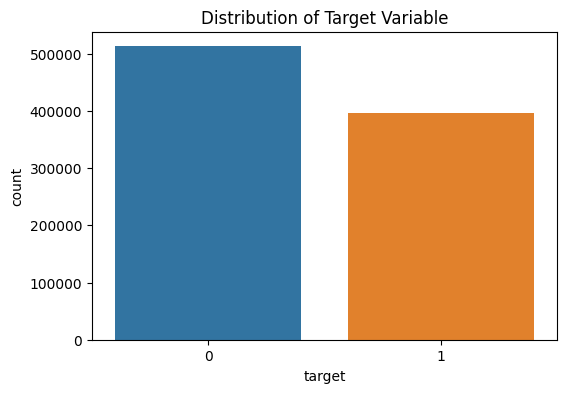

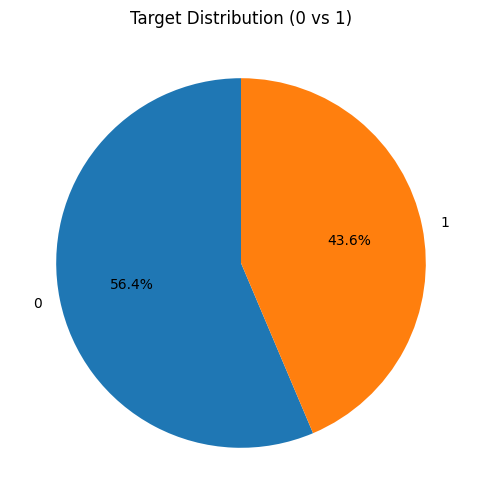

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x=submission_df['target'], hue=submission_df['target'], palette=["#1f77b4", "#ff7f0e"], legend=False)
plt.title('Distribution of Target Variable')
plt.show()

plt.figure(figsize=(6, 6))
plt.pie(
    submission_df['target'].value_counts().values,
    labels=[0, 1],
    autopct='%1.1f%%',
    colors=["#1f77b4", "#ff7f0e"],
    startangle=90
)
plt.title('Target Distribution (0 vs 1)')
plt.show()